# Define BiKA Linear and Conv2d Layer

In [1]:
import math
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F

In [2]:
class CustomSignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Save the input for backward computation
        ctx.save_for_backward(input)
        # Output +1 for input > 0, else -1 (including for input == 0)
        return torch.where(input > 0, torch.tensor(1.0, device=input.device), torch.tensor(-1.0, device=input.device))

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve the input saved in the forward pass
        input, = ctx.saved_tensors
        # Gradient of the input is the same as the gradient output (STE)
        grad_input = grad_output.clone()
        # Pass the gradient only where input was non-zero, otherwise set it to 0
        grad_input[input.abs() > 0] = grad_output[input.abs() > 0]
        return grad_input

# Wrapper class for convenience
class CustomSignActivation(torch.nn.Module):
    def __init__(self):
        super(CustomSignActivation, self).__init__()

    def forward(self, input):
        return CustomSignFunction.apply(input)

# Example usage:
sign_activation = CustomSignActivation()

# Test the forward pass
x = torch.tensor([2.0, -3.0, 0.0, 1.5], requires_grad=True)
output = sign_activation(x)
print("Output during inference:", output)

# Test the backward pass (gradient computation during training)
loss = output.sum()  # Just an example loss
loss.backward()
print("Gradient during training:", x.grad)

Output during inference: tensor([ 1., -1., -1.,  1.], grad_fn=<CustomSignFunctionBackward>)
Gradient during training: tensor([1., 1., 1., 1.])


In [3]:
class BiKALinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BiKALinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sign = CustomSignActivation()
            
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # Expand the input to match the bias shape for broadcasting
        # x is of shape (batch_size, in_features)
        # Expand bias matrix to (batch_size, out_features, in_features)
        x = x.unsqueeze(1) + self.bias.unsqueeze(0)
        
        # Perform element-wise multiplication with weights
        x = x * self.weight.unsqueeze(0)
        
        # Apply sign function: -1 for negative and 0, 1 for positive
        x = self.sign(x)
        
        # Sum the thresholded products along the input features dimension
        x = torch.sum(x, dim=-1) 

        return x

# Example usage
bika_linear = BiKALinear(in_features=2, out_features=3)
input_tensor  = torch.randn(3, 2)  # Batch of 3, 10 input features each
output_tensor = bika_linear(input_tensor)

In [4]:
class BiKAConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(BiKAConv2D, self).__init__()
        # Define weights for convolution
        self.weight = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        )
        # Define an individual bias for each weight in the kernel
        self.bias = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.sign = CustomSignActivation()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

    def forward(self, x):   
        batch_size, in_channels, height, width = x.shape
        out_height = int((height + 2*self.padding-self.dilation*(self.kernel_size-1)-1)/self.stride+1)
        out_width = int((width + 2*self.padding-self.dilation*(self.kernel_size-1)-1)/self.stride+1)
        unfold_length = out_height*out_width
        
        # Add the bias to each activation before multiplying by the weight
        # Equivalent to computing w * (a + b) for each kernel position
        modified_input = F.unfold(x, kernel_size=self.weight.shape[2:], stride=self.stride, padding=self.padding)
        modified_input = modified_input.view(x.shape[0], x.shape[1], self.weight.shape[2], self.weight.shape[3], -1).unsqueeze(1)
        modified_bias = self.bias.unsqueeze(-1).unsqueeze(0)
        modified_input = modified_input + modified_bias
        modified_input = modified_input.view(x.shape[0], -1, modified_input.shape[-1])
        
        # Perform the convolution with the modified input
        modified_weight = self.weight.view(-1).unsqueeze(0).unsqueeze(2)
        output=modified_input * modified_weight
        
        # Apply sign function: -1 for negative and 0, 1 for positive
        output = self.sign(output)
        
        # Sum the thresholded products along the input features dimension
        output = output.view(batch_size, self.out_channels, in_channels*self.kernel_size*self.kernel_size,unfold_length)
        output = output.sum(dim=2) 
        output = output.view(batch_size, self.out_channels, out_height, out_width)

        return output

# Example usage
bika_conv = BiKAConv2D(in_channels=2, out_channels=3, kernel_size=3, stride=1, padding=1)
input_tensor  = torch.arange(0, 36, dtype=torch.float32).reshape(2,2,3,3)
output_tensor = bika_conv(input_tensor)

In [5]:
print(input_tensor)
print(input_tensor.shape)

tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])
torch.Size([2, 2, 3, 3])


In [6]:
print(output_tensor)
print(output_tensor.shape)

tensor([[[[ -2.,  -2.,  -2.],
          [ -4.,  -2.,  -2.],
          [ -8.,  -6.,  -4.]],

         [[  4.,   6.,   8.],
          [  6.,   4.,   8.],
          [  4.,   6.,   8.]],

         [[ -6.,  -2.,  -2.],
          [ -8.,   0.,  -2.],
          [-12.,  -6.,  -6.]]],


        [[[ -2.,   0.,   0.],
          [ -4.,  -2.,  -2.],
          [ -8.,  -6.,  -4.]],

         [[  6.,   6.,   8.],
          [  4.,   4.,   8.],
          [  4.,   6.,   8.]],

         [[ -6.,   0.,  -2.],
          [-10.,   0.,  -2.],
          [-12.,  -6.,  -6.]]]], grad_fn=<ViewBackward0>)
torch.Size([2, 3, 3, 3])


# Try Tiny BiKA with MNIST and output layer

In [7]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [8]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [9]:
import torch

batch_size_train = 512
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [10]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([28, 28])

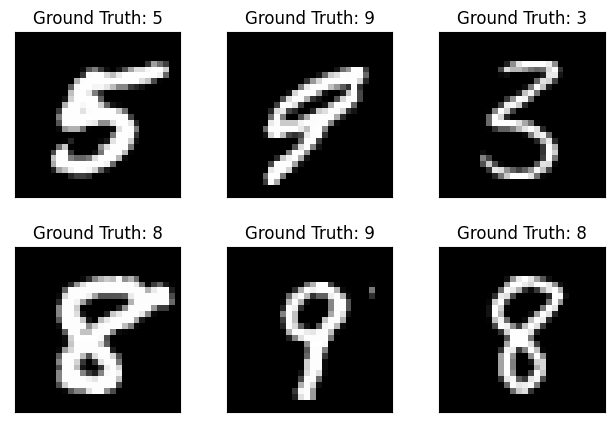

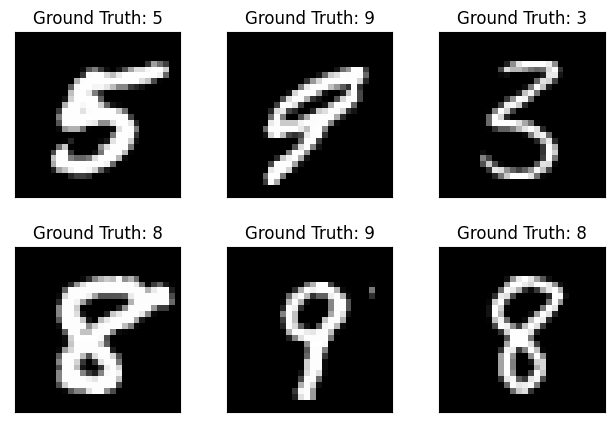

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
kernel_size=3

in_channels0=1
out_channels0=16 

in_channels1=out_channels0
out_channels1=16

input_size = 7*7*out_channels1 
hidden0 = 64   
num_classes = 10  

In [13]:
# Setting seeds for reproducibility
torch.manual_seed(0)

class BiKA_MNIST(Module):
    def __init__(self):
        super(BiKA_MNIST, self).__init__()
        
        self.conv0_0 = BiKAConv2D(in_channels=in_channels0, out_channels=out_channels0, kernel_size=kernel_size, stride=1, padding=1)
        self.conv0_1 = BiKAConv2D(in_channels=out_channels0, out_channels=out_channels0, kernel_size=kernel_size, stride=1, padding=1)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1_0 = BiKAConv2D(in_channels=in_channels1, out_channels=out_channels1, kernel_size=kernel_size, stride=1, padding=1)
        self.conv1_1 = BiKAConv2D(in_channels=out_channels1, out_channels=out_channels1, kernel_size=kernel_size, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc0   = BiKALinear(in_features=input_size, out_features=hidden0)
        
        self.out   = BiKALinear(in_features=hidden0, out_features=num_classes)

    def forward(self, x):
        
        res_in = x
        out = self.conv0_1(self.conv0_0(x))
        out = out + res_in
        
        out = self.pool0(out)
        
        res_in = out
        out = self.conv1_1(self.conv1_0(out))
        out = out + res_in
        
        out = self.pool1(out)
        
        out = out.reshape(out.shape[0], -1)
        out = self.fc0(out)
        out = self.out(out)
        return out
   
model = BiKA_MNIST()

In [14]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [15]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [16]:
num_epochs = 20
learn_rate = 0.0001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [17]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 1.589573 test accuracy = 0.776000: 100%|█| 20/20 [7:38:


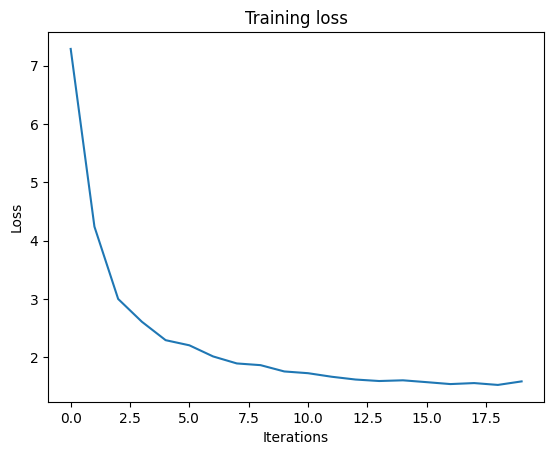

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

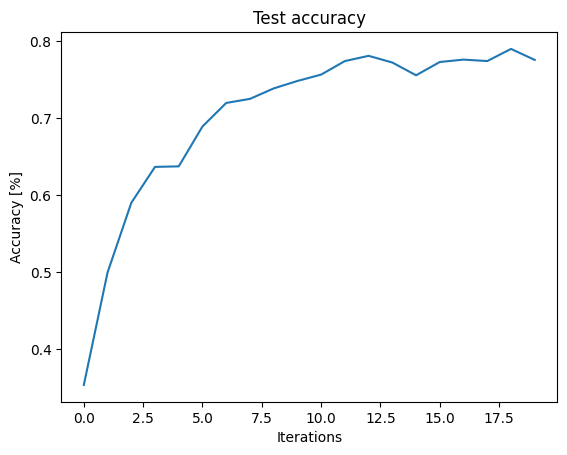

In [20]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [21]:
test(model, data_loader_test)

0.776